# Table of Contents


- **Geting Started**
    - Set Up Environment
    - Import Data
- **ModelSearcher**
    - Define Models & Hyper Parameters to Serach
    - Create/Run the ModelSearcher object
    - Evaluate

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 



# Getting Started

In this notebook, we'll see how to search across different models and hyper-parameters (or the same models and hyper-parameters with different transformations, for example) with the goal of finding the "best" or ideal model candidates for further tuning and optimization.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [2]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreClassificationDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb).

In [3]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [4]:
explore.dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# `ModelSearcher`

A "Searcher" searches across different models and hyper-parameters (or the same models and hyper-parameters with different transformations, for example) with the goal of finding the "best" or ideal model candidates for further tuning and optimization.

We'll supply the searcher with ModelInfo objects, for each model, encapsulates a description, a model object, hyper-param object, and a grid of hyper parameter values to evaluate.  

The data is split (via a Splitter) into training and holding sets. The training set will be used for selecting the "best" hyper parameters via (Tuner & Resampler) and then the model will be retrained and evaluated with selected hyper parameters with the holdout set.

## Define Models & Hyper Parameters to Serach

Below we define the information necessary to search **`Logistic Regression`** and **`Random Forest`** models, across various hyper parameters.

We also include two **`DummyClassifier`** objects. These objects are simple wrappers around **`sklearn.dummy.DummyClassifier`**. The first object (i.e. **`DummyClassifierStrategy.STRATIFIED`**) generates predictions by respecting the training set’s class distribution. The second `DummyClassifier` (i.e. **`DummyClassifierStrategy.MOST_FREQUENT`**) always predicts the most frequent label in the dataset.

These dummy classifiers allow us to compare our results to various random guessing strategies, which is especially useful for datasets that have a high degree of class imbalance (which we do not have in the Titanic dataset).

In [13]:
# Logistic Regression Hyper-Param Grid
log_grid = HyperParamsGrid(params_dict=dict(penalty=['l1', 'l2'],
                                            regularization_inverse=[0.001, 0.01, 0.1, 1, 100, 1000]))

# get the expected columns at the time we do the training, based on the transformations 
columns = TransformerPipeline.get_expected_columns(transformations=global_transformations, data=explore.dataset.drop(columns=[target_variable]))
# Random Forest Hyper-Param Grid
rm_grid = HyperParamsGrid(params_dict=dict(criterion='gini',
                                           max_features=[int(round(len(columns) ** (1 / 2.0))),
                                                         int(round(len(columns) / 2)),
                                                         len(columns) - 1],
                                           n_estimators=[10, 100, 500],
                                           min_samples_leaf=[1, 50, 100]))

# define the models and hyper-parameters that we want to search through
infos = [ModelInfo(description='dummy_stratified',
                   model=DummyClassifier(DummyClassifierStrategy.STRATIFIED),
                   transformations=None,
                   hyper_params=None,
                   hyper_params_grid=None),
         ModelInfo(description='dummy_frequent',
                   model=DummyClassifier(DummyClassifierStrategy.MOST_FREQUENT),
                   transformations=None,
                   hyper_params=None,
                   hyper_params_grid=None),
         ModelInfo(description='Logistic Regression',
                   model=LogisticClassifier(),
                   # transformations specific to this model
                   transformations=[CenterScaleTransformer(),
                                    RemoveCorrelationsTransformer()],
                   hyper_params=LogisticClassifierHP(),
                   hyper_params_grid=log_grid),
         ModelInfo(description='Random Forest',
                   model=RandomForestClassifier(),
                   transformations=None,
                   hyper_params=RandomForestHP(),
                   hyper_params_grid=rm_grid)]


Here are the hyper-parameter combinations we will try out for the **`LogisticClassifier`**:

In [15]:
log_grid.params_grid

,penalty,regularization_inverse
0,l1,0.001
1,l1,0.010
2,l1,0.100
3,l1,1.000
4,l1,100.000
5,l1,1000.000
6,l2,0.001
7,l2,0.010
8,l2,0.100
9,l2,1.000


Here are the hyper-parameter combinations we will try out for the **`RandomForestClassifier`**:

In [14]:
rm_grid.params_grid

,criterion,max_features,n_estimators,min_samples_leaf
0,gini,5,10,1
1,gini,5,10,50
2,gini,5,10,100
3,gini,5,100,1
4,gini,5,100,50
5,gini,5,100,100
6,gini,5,500,1
7,gini,5,500,50
8,gini,5,500,100
9,gini,12,10,1


## Create/Run the ModelSearcher object

In [5]:
# define the transformations that will be applied to ALL models
global_transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                          CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                          ImputationTransformer(),
                          DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

# define the Score objects, which will be used to choose the "best" hyper-parameters for a particular model,
# and compare the performance across model/hyper-params, 
score_list = [AucRocScore(positive_class='lived'),
# the SensitivityScore needs a Converter, 
# which contains the logic necessary to convert the predicted values to a predicted class.
              SensitivityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]

# create the ModelSearcher object
searcher = ModelSearcher(global_transformations=global_transformations,
                         model_infos=infos,
                         splitter=ClassificationStratifiedDataSplitter(holdout_ratio=0.25),
                         resampler_function=lambda m, mt: RepeatedCrossValidationResampler(
                             model=m,
                             transformations=mt,
                             scores=score_list,
                             folds=5,
                             repeats=3))
searcher.search(data=explore.dataset, target_variable='Survived')

## Evaluate

We have access to the **model descriptions** and **model names**.

In [16]:
searcher.results.model_descriptions

['dummy_stratified', 'dummy_frequent', 'Logistic Regression', 'Random Forest']

In [7]:
searcher.results.model_names

['DummyClassifier',
 'DummyClassifier',
 'LogisticClassifier',
 'RandomForestClassifier']

### Resampling Scores


The following plot shows the resampling (AUC) scores for the **best** hyper-parameter combination found, per model.

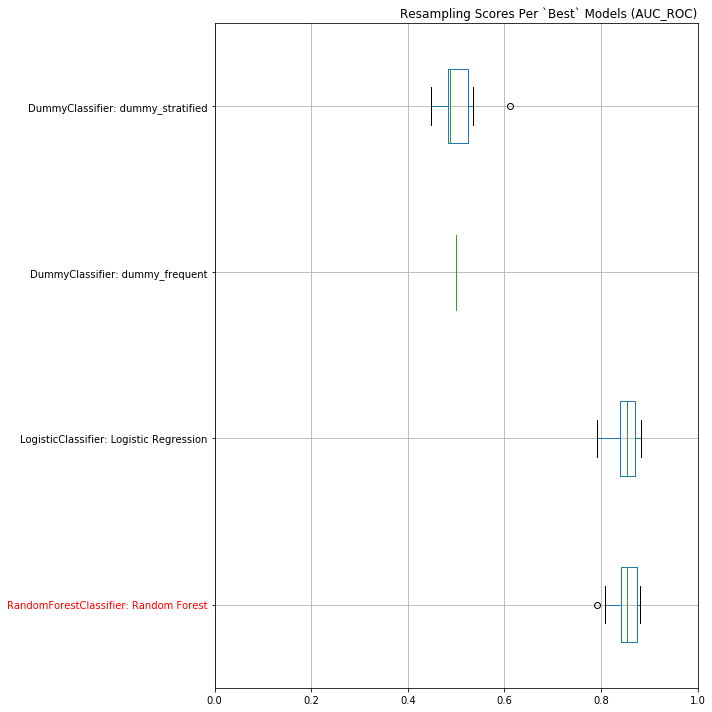

In [11]:
searcher.results.plot_resampled_scores(metric=Metric.AUC_ROC)

The following plot shows the resampling (Sensitivity) scores for the **best** hyper-parameter combination found, per model.

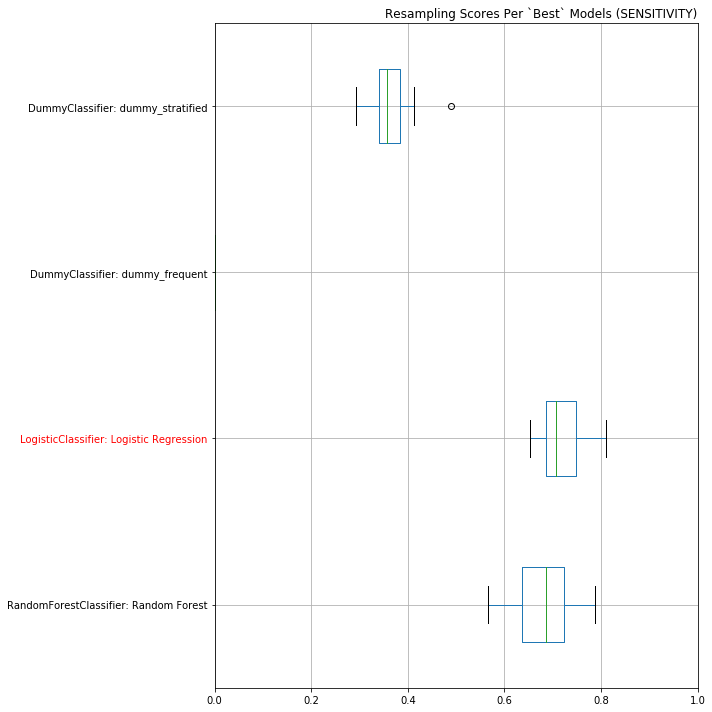

In [12]:
searcher.results.plot_resampled_scores(metric=Metric.SENSITIVITY)

### Holdout Scores

Once the best hyper-parameters for a given model are found via the Resampler, the model and hyper-params are fit on the entire training set and evaluated on the holdout set.

We have access to these holdout scores via the following methods.

In [8]:
searcher.results.holdout_scores

,AUC_ROC,sensitivity
dummy_stratified,0.553047,0.441860
dummy_frequent,0.500000,0.000000
Logistic Regression,0.831735,0.720930
Random Forest,0.821677,0.662791


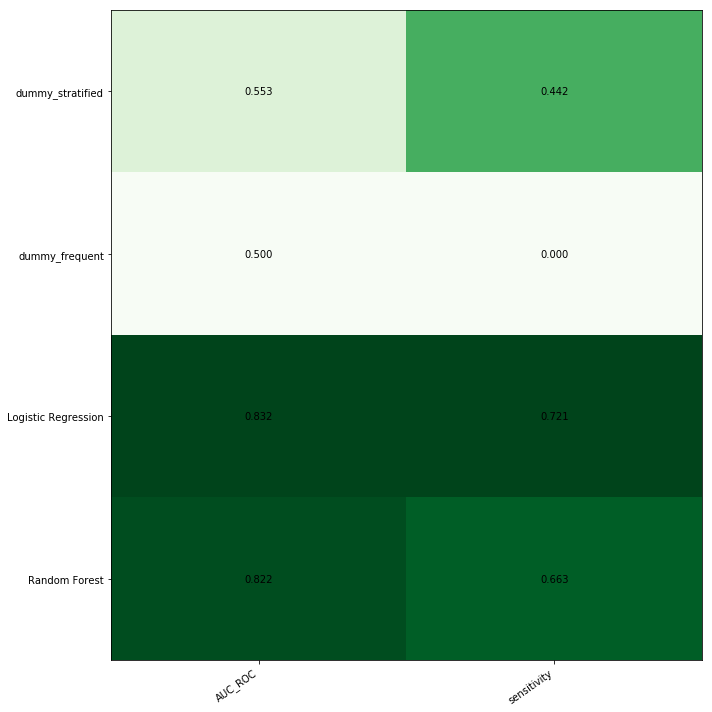

In [9]:
searcher.results.plot_holdout_scores()

In [10]:
searcher.results.best_model_index

2

In [22]:
searcher.results.model_descriptions[searcher.results.best_model_index]

'Logistic Regression'

Although the best model according to the resampled (AUC) scored is Random Forest, the "best" model according to the holdout set is Logistic Regression.